In [38]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset, myNormalize, myToTensor
from torchvision import transforms

In [39]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
#mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = 200)
mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = 200)
my_to_tensor = myToTensor()
transform = transforms.Compose([mynorm, my_to_tensor])

In [41]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11]
train_ds = SNDataset('D:\python\SoilNet\dataset\l8_images\\train\\','D:\python\SoilNet\dataset\LUCAS_2015_all.csv',l8_bands=bands, transform=transform)
test_ds = SNDataset('D:\python\SoilNet\dataset\l8_images\\test\\','D:\python\SoilNet\dataset\LUCAS_2015_all.csv',l8_bands=bands, transform=transform)

In [42]:
# CONFIG
NUM_WORKERS = 2
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 2

In [43]:
train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [44]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dl))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([8, 12, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


In [45]:
from soilnet.soil_net import SoilNetFC, ResNet

In [46]:
#model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
model = ResNet(resnet_architecture="101",cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
img_gpu = img_custom.to(device)
print(img_gpu.device, img_gpu.shape)
print(img_gpu.shape)
y = model(img_gpu)
y.detach()


cuda:0 torch.Size([8, 12, 64, 64])
torch.Size([8, 12, 64, 64])


tensor([[ 3.6530e-05],
        [ 9.0362e-03],
        [-2.6844e-02],
        [-1.2511e-02],
        [ 1.9862e-02],
        [-1.7722e-02],
        [-2.4406e-02],
        [ 9.0447e-03]], device='cuda:0')

In [47]:
torch.min(img_gpu[0]) , torch.min(img_gpu[1])

(tensor(0., device='cuda:0'), tensor(0.0028, device='cuda:0'))

In [48]:
def train_step(model:nn.Module, data_loader:DataLoader, loss_fn:nn.Module, optimizer:torch.optim.Optimizer):
    size = len(data_loader.dataset)
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss = 0
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)


        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y.unsqueeze(1))
        train_loss += loss.item() 


        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss = train_loss / len(data_loader)
    return train_loss

In [49]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [50]:
# x= train_step(model, train_dl, RMSELoss(), torch.optim.Adam(model.parameters(), lr=1e-4))
# x

In [51]:
# Test step function
def test_step(model:nn.Module, data_loader:DataLoader, loss_fn:nn.Module):
    size = len(data_loader.dataset)
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y.unsqueeze(1))
            test_loss += loss.item()
            
            # if batch % 2 == 0:
            #     loss, current = loss.item(), batch * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    test_loss /= len(data_loader)
    print(f"Test Loss: {test_loss:>8f}%")
    return test_loss

In [52]:
# x= test_step(model, test_dl, RMSELoss())
# x

In [53]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = RMSELoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "test_loss": [],
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss = test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | ",
            f"train_loss: {train_loss} | ",
            f"test_loss: {test_loss} | "
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # 6. Return the filled results at the end of the epochs
    return results

## ~~Model is to Small it can't even overfit! | try RESNET~~
## A lower learning rate (1e-5) solved out problem!

In [54]:
results = train(model, train_dl, test_dl, torch.optim.Adam(model.parameters(), lr=1e-6), RMSELoss(), epochs=10) # Make| sure set shuffle for train back to True after testing

  0%|          | 0/10 [00:00<?, ?it/s]

loss: 0.082506  [    0/   52]
loss: 0.070692  [   16/   52]
loss: 0.123845  [   32/   52]
loss: 0.139821  [   24/   52]


 10%|█         | 1/10 [00:11<01:45, 11.73s/it]

Test Loss: 0.102980%
Epoch: 1 |  train_loss: 0.09624461403914861 |  test_loss: 0.10298013925552368 | 
loss: 0.091133  [    0/   52]
loss: 0.091773  [   16/   52]
loss: 0.072275  [   32/   52]
loss: 0.053196  [   24/   52]


 20%|██        | 2/10 [00:23<01:32, 11.56s/it]

Test Loss: 0.090046%
Epoch: 2 |  train_loss: 0.08283182818974767 |  test_loss: 0.09004615232348442 | 
loss: 0.067587  [    0/   52]
loss: 0.080225  [   16/   52]
loss: 0.080467  [   32/   52]
loss: 0.070353  [   24/   52]


 30%|███       | 3/10 [00:34<01:21, 11.66s/it]

Test Loss: 0.074604%
Epoch: 3 |  train_loss: 0.07031070707099778 |  test_loss: 0.07460382707417011 | 
loss: 0.087430  [    0/   52]
loss: 0.035417  [   16/   52]
loss: 0.062589  [   32/   52]
loss: 0.056711  [   24/   52]


 40%|████      | 4/10 [00:47<01:12, 12.03s/it]

Test Loss: 0.061813%
Epoch: 4 |  train_loss: 0.06142656185797283 |  test_loss: 0.06181303203105926 | 
loss: 0.071419  [    0/   52]
loss: 0.046976  [   16/   52]
loss: 0.072309  [   32/   52]
loss: 0.045592  [   24/   52]


 50%|█████     | 5/10 [01:00<01:02, 12.53s/it]

Test Loss: 0.050882%
Epoch: 5 |  train_loss: 0.05465286384735789 |  test_loss: 0.050882250145077704 | 
loss: 0.063432  [    0/   52]
loss: 0.050571  [   16/   52]
loss: 0.049294  [   32/   52]
loss: 0.047133  [   24/   52]


 60%|██████    | 6/10 [01:12<00:48, 12.08s/it]

Test Loss: 0.046721%
Epoch: 6 |  train_loss: 0.05320848258478301 |  test_loss: 0.046721128225326536 | 
loss: 0.046606  [    0/   52]
loss: 0.075590  [   16/   52]
loss: 0.045375  [   32/   52]
loss: 0.036716  [   24/   52]


 70%|███████   | 7/10 [01:19<00:31, 10.63s/it]

Test Loss: 0.048148%
Epoch: 7 |  train_loss: 0.04935242288878986 |  test_loss: 0.04814820542931557 | 
loss: 0.052852  [    0/   52]
loss: 0.038935  [   16/   52]
loss: 0.037179  [   32/   52]
loss: 0.108261  [   24/   52]


 80%|████████  | 8/10 [01:27<00:19,  9.66s/it]

Test Loss: 0.048245%
Epoch: 8 |  train_loss: 0.05296375921794346 |  test_loss: 0.04824506461620331 | 
loss: 0.055415  [    0/   52]
loss: 0.043132  [   16/   52]
loss: 0.076928  [   32/   52]
loss: 0.061443  [   24/   52]


 90%|█████████ | 9/10 [01:34<00:08,  8.98s/it]

Test Loss: 0.044670%
Epoch: 9 |  train_loss: 0.05325131384389741 |  test_loss: 0.04467023983597755 | 
loss: 0.044671  [    0/   52]
loss: 0.072353  [   16/   52]
loss: 0.048237  [   32/   52]
loss: 0.041799  [   24/   52]


100%|██████████| 10/10 [01:42<00:00, 10.22s/it]

Test Loss: 0.046514%
Epoch: 10 |  train_loss: 0.049323750393731255 |  test_loss: 0.04651366759091616 | 


In [55]:
import matplotlib.pyplot as plt

def plot_losses(loss_dict):
    train_losses = loss_dict["train_loss"]
    test_losses = loss_dict["test_loss"]
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.title("Training and Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

somehow the test_loss is smaller than train_loss -> could be due to small smaple dataset

In [56]:
%matplotlib inline

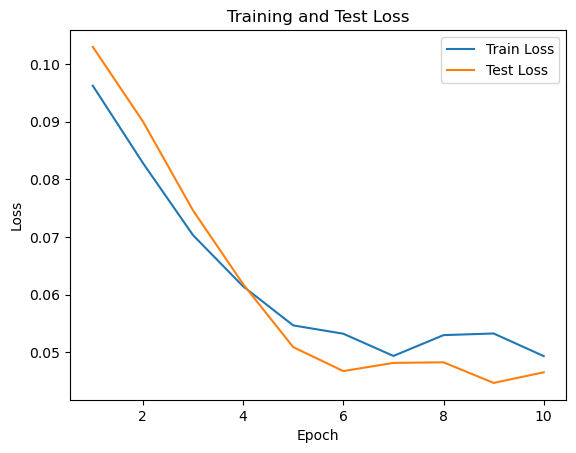

In [57]:
plot_losses(results)